In [52]:
import numpy as np
import matplotlib.pyplot as plt
import time

from vis import *

-0.9999701174172265 1.9999716599170787 0.49987625424183013
(array([300735, 564261, 754649, 766029, 614946, 613827, 765205, 755848,
       564548, 299952]), array([-0.99997012, -0.69997594, -0.39998176, -0.09998758,  0.20000659,
        0.50000077,  0.79999495,  1.09998913,  1.3999833 ,  1.69997748,
        1.99997166]))


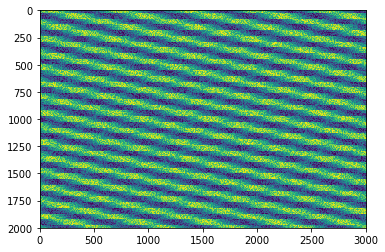

In [56]:
nlin = 2000
ncol = 3000
dem = np.arange(nlin*ncol).reshape(nlin,ncol)
dem = (np.sin(dem * 0.01) + np.random.rand(nlin,ncol))
dem = np.minimum(dem, 50)
print(dem.min(), dem.max(), dem.mean())
plt.imshow(dem)
print(np.histogram(dem))

In [58]:
tic = time.time()
_ = sky_view_factor(dem, 2, compute_svf=True, compute_opns=False, compute_asvf=False,
                    svf_n_dir=32, svf_r_max=10, svf_noise=0, asvf_dir=315, asvf_level=1)
toc = time.time()
print(toc-tic)

27.944010734558105


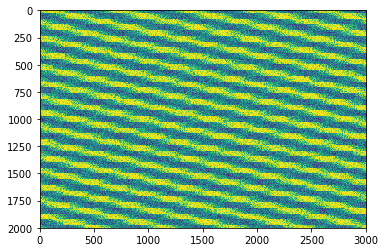

In [59]:
plt.imshow(_["svf"])
#_["svf"].shape

In [91]:
resolution = 2
svf_n_dir=8
svf_r_max=5

In [187]:
def horizon_shift_vector(num_directions, radius_pixels):
    
    # Initialize the output dict
    shift = {}

    # Generate angles and corresponding normal shifts in X (columns)
    # and Y (lines) direction
    angles = (2 * np.pi / num_directions) * np.arange(num_directions) 
    x = np.cos(angles)
    y = np.sin(angles)
    angles = np.round(np.degrees(angles), decimals=1)
    
    # Generate a range of radius values in pixels.
    # Make it finer for the selcted scaling.
    # By adding the last constant we make sure that we do not start with
    # point (0,0).
    scale = 3.
    radii = np.arange(radius_pixels*scale-scale+1) / scale +1

    # For each direction compute all possible horizont point position
    # and round them to integers
    for i in range(num_directions):
        x_int = np.round(x[i] * radii, decimals=0)
        y_int = np.round(y[i] * radii, decimals=0)
        coord_complex = set(x_int + 1j * y_int)
        shift[angles[i]]= [(k.real, k.imag) for k in coord_complex]

    return shift

In [193]:
a=horizon_shift_vector(svf_n_dir, svf_r_max)
for i in a.keys():
    print(f"angle{i}")
    for j in a[i]:
        print(f"shift{j}")

[  0.  45.  90. 135. 180. 225. 270. 315.]
angle0.0
shift(1.0, 0.0)
shift(2.0, 0.0)
shift(3.0, 0.0)
shift(4.0, 0.0)
shift(5.0, 0.0)
angle45.0
shift(2.0, 2.0)
shift(4.0, 4.0)
shift(3.0, 3.0)
shift(1.0, 1.0)
angle90.0
shift(0.0, 1.0)
shift(0.0, 2.0)
shift(0.0, 3.0)
shift(0.0, 4.0)
shift(0.0, 5.0)
angle135.0
shift(-4.0, 4.0)
shift(-1.0, 1.0)
shift(-2.0, 2.0)
shift(-3.0, 3.0)
angle180.0
shift(-2.0, 0.0)
shift(-5.0, 0.0)
shift(-4.0, 0.0)
shift(-3.0, 0.0)
shift(-1.0, 0.0)
angle225.0
shift(-1.0, -1.0)
shift(-4.0, -4.0)
shift(-2.0, -2.0)
shift(-3.0, -3.0)
angle270.0
shift(-0.0, -5.0)
shift(-0.0, -4.0)
shift(-0.0, -3.0)
shift(-0.0, -1.0)
shift(-0.0, -2.0)
angle315.0
shift(4.0, -4.0)
shift(3.0, -3.0)
shift(1.0, -1.0)
shift(2.0, -2.0)


In [145]:
em1 = np.pad(dem, svf_r_max, mode='symmetric')
svf = np.zeros(dem1.shape)
horizon = np.zeros(dem1.shape)

for dir in range(svf_n_dir):
    for r in range(svf_r_max):

        _ = (np.roll(dem1, shift, axes=(0,1)) - dem1) / r

    

NameError: name 'shift' is not defined